In [1]:
!git clone https://github.com/openai/CLIP.git
%cd CLIP/
%pip install ftfy
import clip
%cd ../

fatal: destination path 'CLIP' already exists and is not an empty directory.
/home/ubuntu/isa_CSC413_project/CLIP


Looking in indexes: https://pypi.internal-mirrors.ucloud.cn/simple
Note: you may need to restart the kernel to use updated packages.
/home/ubuntu/isa_CSC413_project


In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Load clip
perceptor, preprocess = clip.load('ViT-B/32')
perceptor = perceptor.to(device)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [5]:
%pip install huggingface_hub

Looking in indexes: https://pypi.internal-mirrors.ucloud.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [6]:
from huggingface_hub import hf_hub_download

weights_path = hf_hub_download(
    repo_id="lfw3/Genshin_Stats_MLP_to_CLIP",
    filename="best_model_weights.pt"
)

# mlp.py contains the model architecture (class definition)
code_path = hf_hub_download(
    repo_id="lfw3/Genshin_Stats_MLP_to_CLIP",
    filename="clip_mlp.py"
)

/home/ubuntu/anaconda3/envs/isaenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import importlib.util
spec = importlib.util.spec_from_file_location("mlp", code_path)
mlp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mlp_module)

MLP = mlp_module.CLIPOffsetMLP

In [8]:
model = MLP()
checkpoint = torch.load(weights_path, map_location="cpu")
state = torch.load(weights_path, map_location="cpu")
# state = checkpoint["model_state_dict"]
model.load_state_dict(state)
model.to("cuda")
model.eval()

CLIPOffsetMLP(
  (mlp): Sequential(
    (0): Linear(in_features=1559, out_features=1024, bias=True)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=512, out_features=512, bias=True)
  )
)

# Load the diffuser model


In [9]:
%%capture
%pip install -U peft transformers diffusers

In [10]:
from diffusers import DiffusionPipeline

# Load Stable Diffusion XL Base1.0
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
).to("cuda")

# Optional CPU offloading to save some GPU Memory
pipe.enable_model_cpu_offload()

# # Loading Trained LoRA Weights
# Can be a path to a local folder, or a huggingface model hub repo
pipe.load_lora_weights("mary-ruiliii/genshin-style_character_generator")

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


In [ ]:
from huggingface_hub import HfApi, upload_folder

api = HfApi()

api.create_repo(
    repo_id="mary-ruiliii/Genshin-SDXL-LORA-MLP-Projector",
    repo_type="model",
    exist_ok=True    # avoids error if it already exists
)

upload_folder(
    folder_path="/home/ubuntu/diffusers/examples/textual_inversion/Genshin_ti_sdxl",
    repo_id="mary-ruiliii/Genshin-SDXL-LORA-MLP-Projector",
    repo_type="model"
)

/home/ubuntu/anaconda3/envs/isaenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

Processing Files (0 / 1)                :   0%|          | 24.6MB / 6.96GB,   ???B/s  
Processing Files (0 / 1)                :   1%|▏         | 91.6MB / 6.96GB,  335MB/s  
Processing Files (0 / 1)                :   2%|▏         |  166MB / 6.96GB,  352MB/s  






















Processing Files (0 / 4)                :   4%|▍         |  281MB / 6.96GB,  183MB/s  









Processing Files (0 / 4)                :   7%|▋         |  460MB / 6.96GB,  272MB/s  









Processing Files (0 / 4)                :   9%|▉         |  650MB / 6.96GB,  347MB/s  









Processing Files (0 / 4)                :  11%|█▏        |  793MB / 6.96GB, 

In [ ]:
# load projector
import safetensors.torch as safet

class Projector(torch.nn.Module):
    def __init__(self, in_dim=512, out_dim=2048, num_vectors=1):
        super().__init__()
        self.num_vectors = num_vectors
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_dim, 1024),
            torch.nn.SiLU(),
            torch.nn.Linear(1024, out_dim * num_vectors),
        )

    def forward(self, x):  # x: [B, 512]
        y = self.net(x)  # [B, out_dim * num_vectors]
        return y.view(x.shape[0], self.num_vectors, -1)  # [B, num_vectors, out_dim]

d1 = pipe.text_encoder.config.hidden_size     # 768
d2 = pipe.text_encoder_2.config.hidden_size   # 1280

projector = Projector(in_dim=512, out_dim=d1+d2)
proj_state = safet.load_file("/home/ubuntu/diffusers/examples/textual_inversion/Genshin_ti_sdxl/learned_projector.safetensors", device="cpu")
projector.load_state_dict(proj_state)
projector.eval().to(device)

Projector(
  (net): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=2048, bias=True)
  )
)

In [ ]:
# load original embeddings
prompt = "A human Genshin-style character. uses a claymore. has a Electro vision. medium male body figure. from Mondstadt. affiliation: Knights of Favonius, name: Albeless, constellation: Fox. highly detailed, intricate, elegant, beautiful, artstation, concept art, digital art"

# Tokenize
ids1 = pipe.tokenizer(prompt, return_tensors="pt",
                      padding="max_length",
                      max_length=pipe.tokenizer.model_max_length).input_ids.to(device)
ids2 = pipe.tokenizer_2(prompt, return_tensors="pt",
                        padding="max_length",
                        max_length=pipe.tokenizer_2.model_max_length).input_ids.to(device)

# Encode text
enc1_out = pipe.text_encoder(ids1, output_hidden_states=True)
enc2_out = pipe.text_encoder_2(ids2, output_hidden_states=True)

enc1 = enc1_out.hidden_states[-2]   # [1,77,768]
enc2 = enc2_out.hidden_states[-2]   # [1,77,1280]

# Pooled embeddings (needed by SDXL)
pooled = enc2_out.text_embeds.half().cuda()       # [1,1280]

# Concatenate full embeddings
prompt_embeds = torch.cat([enc1.half().cuda(), enc2.half().cuda()], dim=-1)  # [1,77,2048]


In [ ]:
# prepare projector vector
# Example character fields
name = "Albeless"
constellation = "Fox"
affiliation = "Knights of Favonius"
region = "Mondstadt"
vision = "Electro"
weapon = "Claymore"
body = "Medium Male"

REGION_LIST = ['Mondstadt', 'Sumeru', 'Inazuma', 'Liyue', 'Fontaine', 'Snezhnaya']
VISION_LIST = ['Geo', 'Dendro', 'Pyro', 'Hydro', 'Electro', 'Cryo', 'Anemo']
WEAPON_LIST = ['Sword', 'Bow', 'Claymore', 'Catalyst', 'Polearm']
BODY_LIST   = ['Medium Male', 'Tall Male', 'Medium Female', 'Tall Female', 'Short Female']

REGION2ID  = {n: i for i, n in enumerate(REGION_LIST)}
VISION2ID  = {n: i for i, n in enumerate(VISION_LIST)}
WEAPON2ID  = {n: i for i, n in enumerate(WEAPON_LIST)}
BODY2ID    = {n: i for i, n in enumerate(BODY_LIST)}

# Encode CLIP strings
E_name = perceptor.encode_text(clip.tokenize([name]).to(device))
E_const = perceptor.encode_text(clip.tokenize([constellation]).to(device))
E_aff = perceptor.encode_text(clip.tokenize([affiliation]).to(device))
E_base = perceptor.encode_text(clip.tokenize(["Genshin-style character"]).to(device))

string_embeds = torch.stack([E_name, E_const, E_aff], dim=1)  # [1,3,512]

# categorical encoding
import torch
cat = torch.tensor([[REGION2ID[region], VISION2ID[vision], WEAPON2ID[weapon], BODY2ID[body]]]).to(device)   # replace with real IDs

with torch.no_grad():
    mlp_out = model(string_embeds, cat, E_base)   # [1,512]
    proj_vec = projector(mlp_out)[0,0].half().cuda()     # [2048]
    print(proj_vec.dtype)

# inject projected vector into prompt embeddings
prompt_embeds[:, -1, :] = proj_vec

my_prompt_embeds = prompt_embeds.half().cuda()  
my_pooled_embeds = pooled.half().cuda()  


torch.float16


In [ ]:
# Invoke pipeline to generate image
prompt_embeds_test = torch.zeros_like(my_pooled_embeds)
image = pipe(
    prompt_embeds=my_prompt_embeds,
    pooled_prompt_embeds=my_pooled_embeds,
    num_inference_steps=50,
    guidance_scale=7.0,
    height=400,
    width=400
).images[0]
# prompt = "Genshin-style character, tall male, pyro vision, from Mondstadt"

# Invoke pipeline to generate image
# image = pipe(
#     prompt = prompt,
#     num_inference_steps=50,
#     height=400,
#     width=400,
#     guidance_scale=7.0,
# ).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:06<00:00,  7.32it/s]
/home/ubuntu/anaconda3/envs/isaenv/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


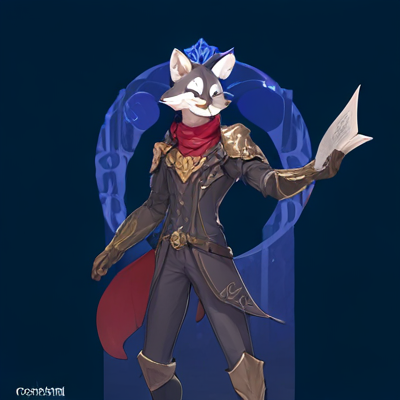

In [ ]:
image

In [16]:
# Save Image
image.save(f"electro_fox_base_projector.png")